In [ ]:
# importing the libraries
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from IPython.display import clear_output


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/Shareddrives/ShupponKu/split-output-wsample.zip'

In [ ]:
data_dir = '/content/split-output/'

In [ ]:
train_folder= os.path.join(data_dir,'train')
valid_folder= os.path.join(data_dir,'val')
sample_folder= os.path.join(data_dir,'sample')
test_folder= os.path.join(data_dir,'test')
num_of_training_img = len(os.listdir(train_folder + '/images')) 
num_of_training_mask = len(os.listdir(train_folder + '/masks'))
num_of_val_img = len(os.listdir(valid_folder + '/images'))
num_of_test_img = len(os.listdir(test_folder + '/images'))

In [ ]:
print(f"There are {num_of_training_img} images.\n")
print(f"There are {num_of_training_mask} masks.\n")

There are 4086 images.

There are 4086 masks.



--BATAS SUCI--

In [ ]:
train_dir=train_folder
val_dir=valid_folder
test_dir=test_folder
sample_dir = sample_folder

In [ ]:
img_dim = 256
BATCH_SIZE = 32 
seed = 42

In [ ]:
from PIL import Image
import random
import seaborn as sns

In [ ]:
tr_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_image_generator = tr_datagen.flow_from_directory(
        train_dir,
        classes=['images'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        batch_size = BATCH_SIZE,
)
    
train_mask_generator = tr_datagen.flow_from_directory(
        train_dir,
        classes=['masks'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        color_mode='grayscale',
        batch_size = BATCH_SIZE,
)

val_image_generator = val_datagen.flow_from_directory(
        val_dir,
        classes=['images'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        batch_size = BATCH_SIZE,

)
    
val_mask_generator = val_datagen.flow_from_directory(
        val_dir,
        classes=['masks'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        color_mode='grayscale',
        batch_size = BATCH_SIZE,
)
test_image_generator = val_datagen.flow_from_directory(
        test_dir,
        classes=['images'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        batch_size = BATCH_SIZE,

)
    
test_mask_generator = val_datagen.flow_from_directory(
        test_dir,
        classes=['masks'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        color_mode='grayscale',
        batch_size = BATCH_SIZE,
)
sam_image_generator = val_datagen.flow_from_directory(
        sample_folder,
        classes=['images'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        batch_size = BATCH_SIZE,

)
    
sam_mask_generator = val_datagen.flow_from_directory(
        sample_folder,
        classes=['masks'],
        shuffle=False,
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        color_mode='grayscale',
        batch_size = BATCH_SIZE,
)

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)
test_generator = zip(test_image_generator, test_mask_generator)
sample_generator = zip(sam_image_generator, sam_mask_generator)

Found 4086 images belonging to 1 classes.
Found 4086 images belonging to 1 classes.
Found 510 images belonging to 1 classes.
Found 510 images belonging to 1 classes.
Found 512 images belonging to 1 classes.
Found 512 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


In [ ]:
# helper function to display an image, it's label and the prediction
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
        plt.axis('off')
    plt.show()

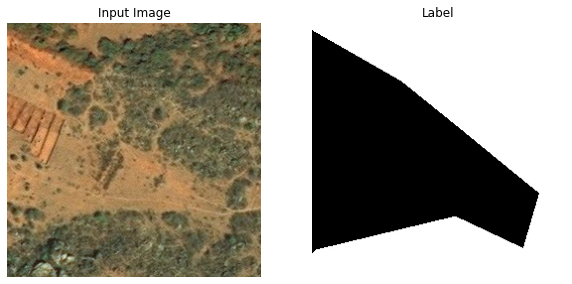

In [ ]:
num_sample = 1
n = 0
# print(train_image_generator.shape)
for image, mask in sample_generator:
    sample_image, sample_label = image[0], mask[0]
    if n < num_sample:
        display([sample_image, sample_label])
        n+=1
    else:
        break

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *

In [ ]:
def fcn(image_size, ch_in=3, ch_out=1):
    
    inputs = Input(shape=(*image_size, ch_in), name='input')

    # Building a pre-trained VGG-16 feature extractor (i.e., without the final FC layers)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    # Recovering the feature maps generated by each of the 3 final blocks:
    f3 = vgg16.get_layer('block3_pool').output  
    f4 = vgg16.get_layer('block4_pool').output  
    f5 = vgg16.get_layer('block5_pool').output  

    conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(f5)
    conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)

    conv_8 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_8")(f4)
    conv_9 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_9")(f3)
    
    deconv_7 = Conv2DTranspose(1024, kernel_size=(2,2), strides=(2,2))(conv_7)
    add_1 = Add()([deconv_7, conv_8])
    deconv_8 = Conv2DTranspose(1024, kernel_size=(2,2), strides=(2,2))(add_1)
    add_2 = Add()([deconv_8, conv_9])

    outputs = Conv2DTranspose(filters=ch_out, kernel_size=8, strides=8,
                              padding='same', activation="sigmoid")(add_2)
                              
    # outputs = Conv2D(3, 1, padding="same", activation="sigmoid")(deconv)
        
    fcn_model = Model(inputs, outputs)
    return fcn_model

In [ ]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=0.0001):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32')
    intersect = K.sum(K.abs(y_true * y_pred), axis=[1,2])
    fsum = K.sum(y_true,[1,2])
    ssum = K.sum(y_pred,[1,2])
    dice = (2 * intersect + smooth ) / (fsum + ssum + smooth)
    dice = K.mean(dice)
    return dice  

def iou_coef(y_true, y_pred, smooth=0.0001):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # .5 is the threshold
    inter = K.sum(K.sum(K.squeeze(y_true * y_pred, axis=3), axis=2), axis=1)
    union = K.sum(K.sum(K.squeeze(y_true + y_pred, axis=3), axis=2), axis=1) - inter
    return K.mean((inter + K.epsilon() + smooth) / (union + K.epsilon() + smooth ))

In [ ]:
# defining the tensorflow distribute strategy
# strategy = tf.distribute.MirroredStrategy()

In [ ]:
# # calling the model inside the scope
# with strategy.scope():
model = fcn((img_dim, img_dim))
# compiling the model with the optimizer, loss function and acc metrics
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
            loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[iou_coef,dice_coef,'accuracy', 'mse'])

58889256/58889256 [==============================] - 0s 0us/step


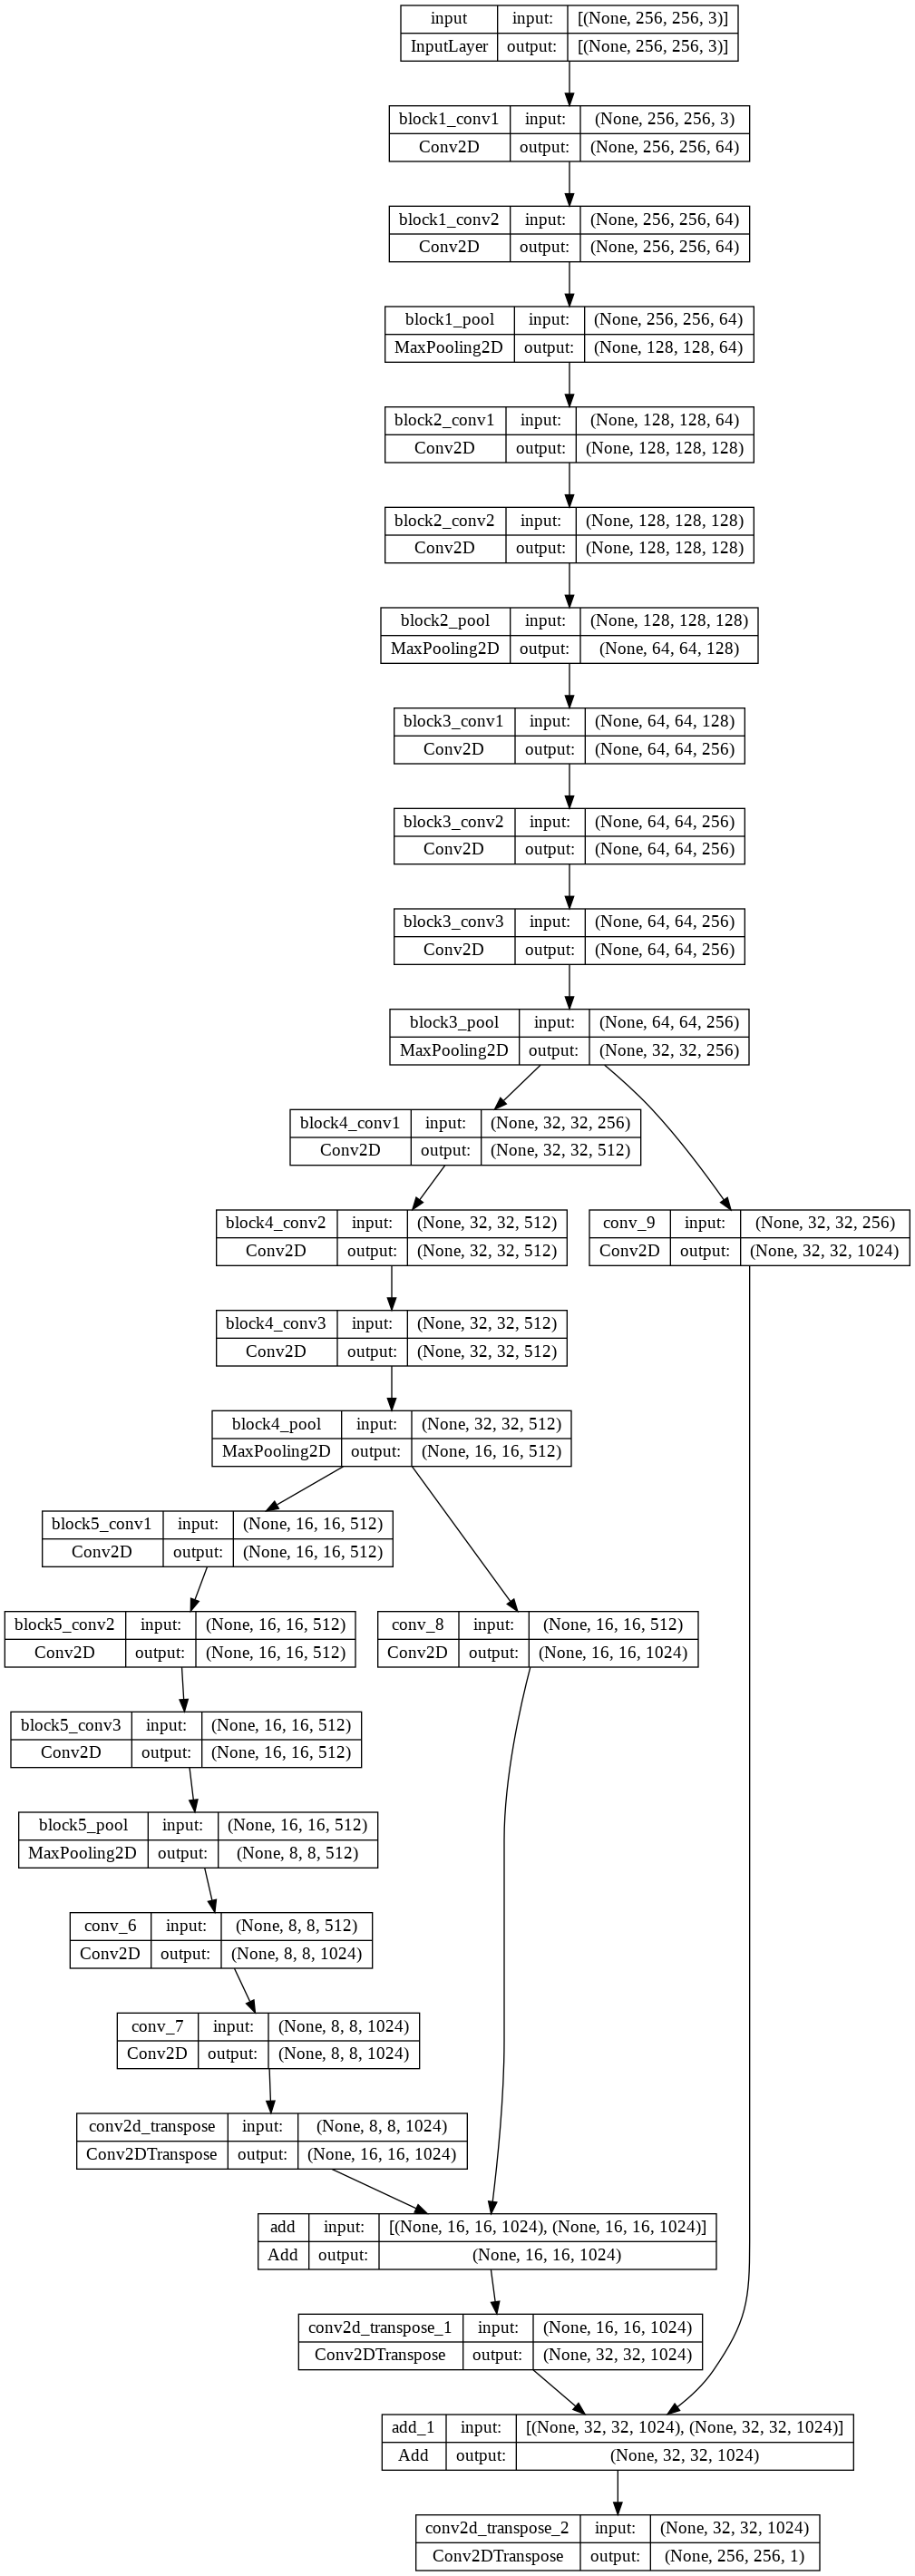

In [ ]:
# let's see how our FCN implemented model looks like
# does it looks like the architecture fig above?
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# function to show the prediction
def show_predictions(dataset=None, num=1):
  if dataset:
    n = 0
    for image, mask in dataset:
      image, mask = image, mask
      if n < num:
        # pred_mask = model.predict(image)
        # print(pred_mask)
        result = model.predict(image)
        output = result[0]
        output[output >= 0.5] = 1
        output[output < 0.5] = 0
        print(f'image shape {image.shape}')
        print(f'mask shape {mask.shape}')
        print(f'pred_mask shape {result.shape}')
        display([image[0], mask[0], output])
        n+=1
      else:
        break
  else:
    result = model.predict(sample_image[tf.newaxis, ...])
    output = result[0]
    output[output >= 0.5] = 1
    output[output < 0.5] = 0
    display([sample_image, sample_label, output])

1/1 [==============================] - 12s 12s/step
image shape (32, 256, 256, 3)
mask shape (32, 256, 256, 1)
pred_mask shape (32, 256, 256, 1)


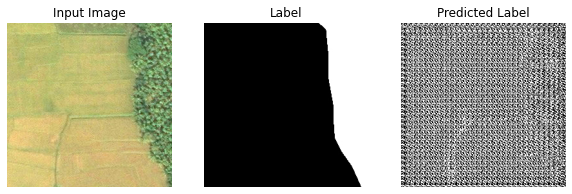

In [ ]:
# # Let's see a sample of input image it's true mask and what our model is predicted given the input image
show_predictions(test_generator)

In [ ]:
# calllback to displaying the predictions of our model while training
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
   
 # ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0, patience = 5, verbose = 1)


Epoch 1/50
1/1 [==============================] - 1s 837ms/step


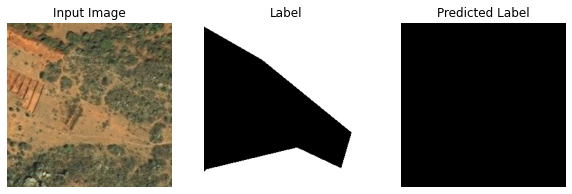


Sample Prediction after epoch 1

127/127 [==============================] - 120s 887ms/step - loss: 0.6917 - iou_coef: 0.5282 - dice_coef: 0.6160 - accuracy: 0.5674 - mse: 0.2441 - val_loss: 0.6769 - val_iou_coef: 0.6199 - val_dice_coef: 0.7019 - val_accuracy: 0.6133 - val_mse: 0.2418 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 0s 17ms/step


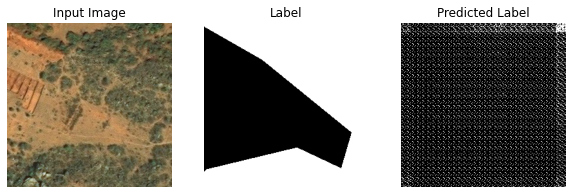


Sample Prediction after epoch 2

127/127 [==============================] - 116s 863ms/step - loss: 0.6874 - iou_coef: 0.5941 - dice_coef: 0.6770 - accuracy: 0.5881 - mse: 0.2426 - val_loss: 0.7090 - val_iou_coef: 0.1129 - val_dice_coef: 0.1999 - val_accuracy: 0.4119 - val_mse: 0.2578 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 0s 17ms/step


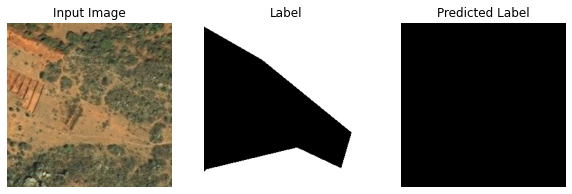


Sample Prediction after epoch 3

127/127 [==============================] - 111s 878ms/step - loss: 0.6774 - iou_coef: 0.5828 - dice_coef: 0.6664 - accuracy: 0.5828 - mse: 0.2408 - val_loss: 0.6733 - val_iou_coef: 0.6199 - val_dice_coef: 0.7019 - val_accuracy: 0.6133 - val_mse: 0.2400 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 0s 17ms/step


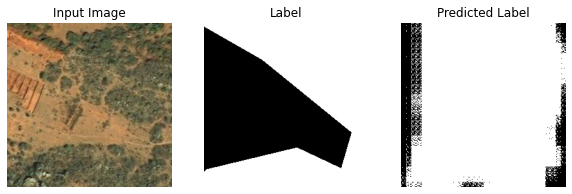


Sample Prediction after epoch 4

127/127 [==============================] - 110s 865ms/step - loss: 0.6820 - iou_coef: 0.5808 - dice_coef: 0.6683 - accuracy: 0.5779 - mse: 0.2424 - val_loss: 0.6568 - val_iou_coef: 0.5989 - val_dice_coef: 0.6863 - val_accuracy: 0.6299 - val_mse: 0.2319 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 0s 17ms/step


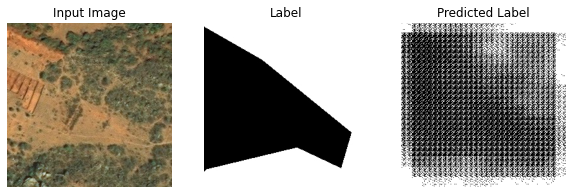


Sample Prediction after epoch 5

127/127 [==============================] - 110s 870ms/step - loss: 0.6756 - iou_coef: 0.6051 - dice_coef: 0.6870 - accuracy: 0.5909 - mse: 0.2399 - val_loss: 0.6707 - val_iou_coef: 0.4690 - val_dice_coef: 0.5876 - val_accuracy: 0.6216 - val_mse: 0.2387 - lr: 0.0010
Epoch 6/50
1/1 [==============================] - 0s 17ms/step


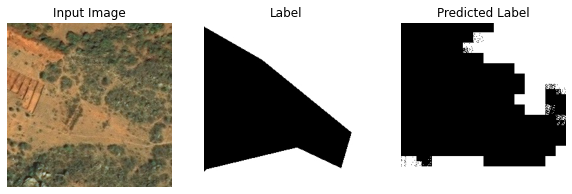


Sample Prediction after epoch 6

127/127 [==============================] - 110s 864ms/step - loss: 0.6626 - iou_coef: 0.5870 - dice_coef: 0.6725 - accuracy: 0.6201 - mse: 0.2294 - val_loss: 0.8515 - val_iou_coef: 0.4740 - val_dice_coef: 0.5572 - val_accuracy: 0.6889 - val_mse: 0.2507 - lr: 0.0010
Epoch 7/50
1/1 [==============================] - 0s 28ms/step


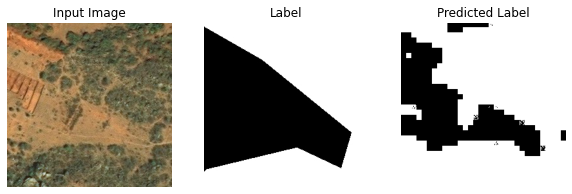


Sample Prediction after epoch 7

127/127 [==============================] - 111s 872ms/step - loss: 0.6565 - iou_coef: 0.5367 - dice_coef: 0.6147 - accuracy: 0.6259 - mse: 0.2236 - val_loss: 0.5634 - val_iou_coef: 0.6373 - val_dice_coef: 0.7223 - val_accuracy: 0.7442 - val_mse: 0.1880 - lr: 0.0010
Epoch 8/50
1/1 [==============================] - 0s 17ms/step


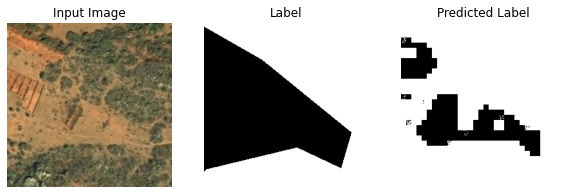


Sample Prediction after epoch 8

127/127 [==============================] - 110s 866ms/step - loss: 0.5963 - iou_coef: 0.6139 - dice_coef: 0.7025 - accuracy: 0.7064 - mse: 0.1971 - val_loss: 0.5462 - val_iou_coef: 0.6449 - val_dice_coef: 0.7290 - val_accuracy: 0.7413 - val_mse: 0.1812 - lr: 0.0010
Epoch 9/50
1/1 [==============================] - 0s 17ms/step


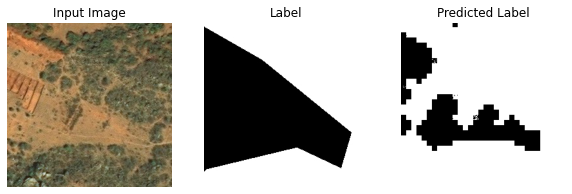


Sample Prediction after epoch 9

127/127 [==============================] - 110s 870ms/step - loss: 0.5652 - iou_coef: 0.6155 - dice_coef: 0.7027 - accuracy: 0.7185 - mse: 0.1870 - val_loss: 0.5209 - val_iou_coef: 0.6479 - val_dice_coef: 0.7314 - val_accuracy: 0.7545 - val_mse: 0.1705 - lr: 0.0010
Epoch 10/50
1/1 [==============================] - 0s 21ms/step


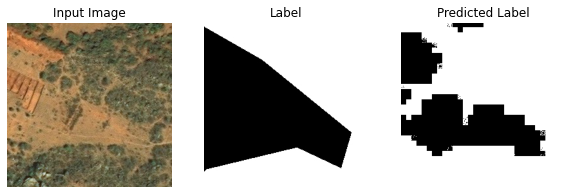


Sample Prediction after epoch 10

127/127 [==============================] - 110s 864ms/step - loss: 0.5346 - iou_coef: 0.6178 - dice_coef: 0.7060 - accuracy: 0.7354 - mse: 0.1743 - val_loss: 0.5188 - val_iou_coef: 0.6438 - val_dice_coef: 0.7300 - val_accuracy: 0.7778 - val_mse: 0.1668 - lr: 0.0010
Epoch 11/50
1/1 [==============================] - 0s 16ms/step


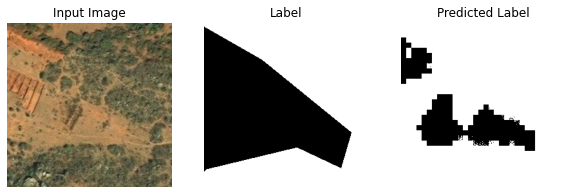


Sample Prediction after epoch 11

127/127 [==============================] - 111s 874ms/step - loss: 0.5387 - iou_coef: 0.6198 - dice_coef: 0.7078 - accuracy: 0.7332 - mse: 0.1759 - val_loss: 0.4908 - val_iou_coef: 0.6597 - val_dice_coef: 0.7423 - val_accuracy: 0.7670 - val_mse: 0.1594 - lr: 0.0010
Epoch 12/50
1/1 [==============================] - 0s 16ms/step


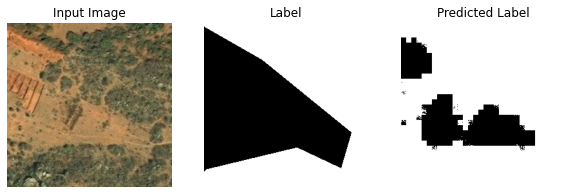


Sample Prediction after epoch 12

127/127 [==============================] - 110s 864ms/step - loss: 0.5268 - iou_coef: 0.6205 - dice_coef: 0.7069 - accuracy: 0.7347 - mse: 0.1723 - val_loss: 0.4880 - val_iou_coef: 0.6592 - val_dice_coef: 0.7423 - val_accuracy: 0.7762 - val_mse: 0.1567 - lr: 0.0010
Epoch 13/50
1/1 [==============================] - 0s 17ms/step


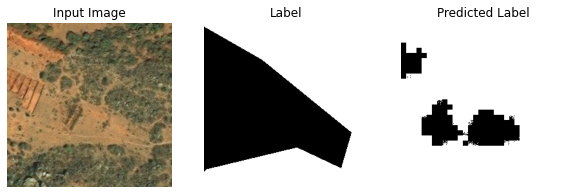


Sample Prediction after epoch 13

127/127 [==============================] - 111s 872ms/step - loss: 0.5075 - iou_coef: 0.6299 - dice_coef: 0.7152 - accuracy: 0.7548 - mse: 0.1630 - val_loss: 0.4930 - val_iou_coef: 0.6638 - val_dice_coef: 0.7450 - val_accuracy: 0.7686 - val_mse: 0.1599 - lr: 0.0010
Epoch 14/50
1/1 [==============================] - 0s 17ms/step


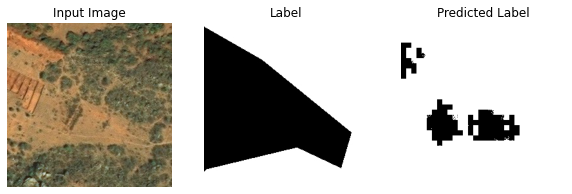


Sample Prediction after epoch 14

127/127 [==============================] - 111s 874ms/step - loss: 0.5022 - iou_coef: 0.6289 - dice_coef: 0.7132 - accuracy: 0.7550 - mse: 0.1617 - val_loss: 0.4959 - val_iou_coef: 0.6638 - val_dice_coef: 0.7457 - val_accuracy: 0.7652 - val_mse: 0.1612 - lr: 0.0010
Epoch 15/50
1/1 [==============================] - 0s 17ms/step


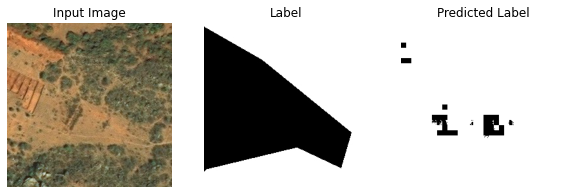


Sample Prediction after epoch 15

127/127 [==============================] - 110s 866ms/step - loss: 0.4940 - iou_coef: 0.6337 - dice_coef: 0.7176 - accuracy: 0.7574 - mse: 0.1593 - val_loss: 0.5235 - val_iou_coef: 0.6648 - val_dice_coef: 0.7458 - val_accuracy: 0.7529 - val_mse: 0.1701 - lr: 0.0010
Epoch 16/50
1/1 [==============================] - 0s 16ms/step


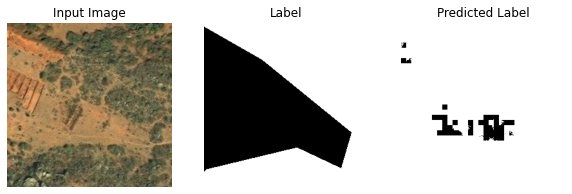


Sample Prediction after epoch 16

127/127 [==============================] - 111s 875ms/step - loss: 0.4955 - iou_coef: 0.6324 - dice_coef: 0.7163 - accuracy: 0.7568 - mse: 0.1598 - val_loss: 0.5154 - val_iou_coef: 0.6648 - val_dice_coef: 0.7462 - val_accuracy: 0.7572 - val_mse: 0.1674 - lr: 0.0010
Epoch 17/50
1/1 [==============================] - 0s 17ms/step


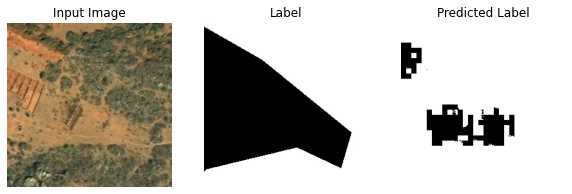


Sample Prediction after epoch 17

127/127 [==============================] - 110s 868ms/step - loss: 0.4979 - iou_coef: 0.6310 - dice_coef: 0.7132 - accuracy: 0.7560 - mse: 0.1606 - val_loss: 0.4944 - val_iou_coef: 0.6655 - val_dice_coef: 0.7470 - val_accuracy: 0.7745 - val_mse: 0.1578 - lr: 0.0010
Epoch 17: early stopping


In [ ]:
# defining some hyperparameters
TRAIN_LENGTH = num_of_training_img
#128
STEPS_PER_EPOCH = TRAIN_LENGTH//BATCH_SIZE

EPOCHS = 50
TEST_SIZE = num_of_val_img
VALIDATION_STEPS = TEST_SIZE//BATCH_SIZE#//VAL_SUBSPLITS

model_history = model.fit(train_generator, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_generator,
                          callbacks=[DisplayCallback(), reduce_lr, early_stopping]
                          )

In [ ]:
model.evaluate(test_generator, steps=num_of_test_img)

512/512 [==============================] - 135s 264ms/step - loss: 0.4453 - iou_coef: 0.6948 - dice_coef: 0.7753 - accuracy: 0.7983 - mse: 0.1406


[0.44528305530548096,
 0.6948464512825012,
 0.7752895355224609,
 0.7983223795890808,
 0.14061787724494934]

1/1 [==============================] - 0s 18ms/step
image shape (1, 256, 256, 3)
mask shape (1, 256, 256, 1)
pred_mask shape (1, 256, 256, 1)


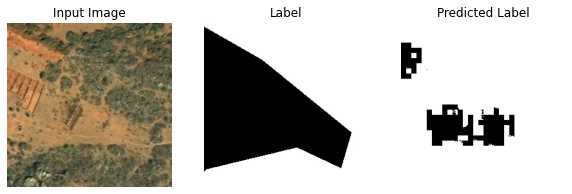

In [ ]:
show_predictions(sample_generator)

1/1 [==============================] - 0s 29ms/step
image shape (32, 256, 256, 3)
mask shape (32, 256, 256, 1)
pred_mask shape (32, 256, 256, 1)


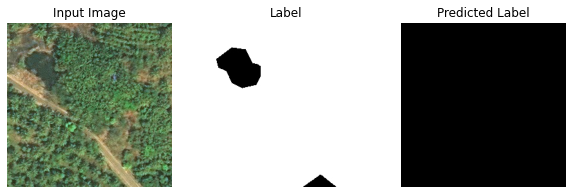

1/1 [==============================] - 0s 29ms/step
image shape (32, 256, 256, 3)
mask shape (32, 256, 256, 1)
pred_mask shape (32, 256, 256, 1)


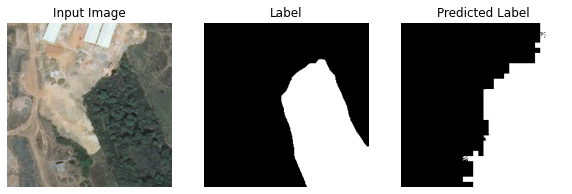

1/1 [==============================] - 0s 30ms/step
image shape (32, 256, 256, 3)
mask shape (32, 256, 256, 1)
pred_mask shape (32, 256, 256, 1)


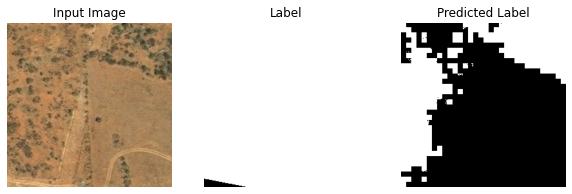

1/1 [==============================] - 0s 31ms/step
image shape (32, 256, 256, 3)
mask shape (32, 256, 256, 1)
pred_mask shape (32, 256, 256, 1)


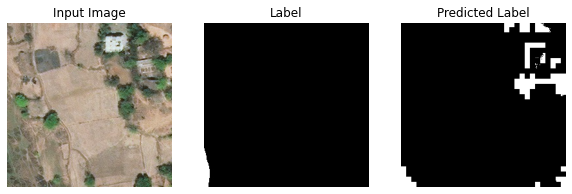

1/1 [==============================] - 0s 28ms/step
image shape (32, 256, 256, 3)
mask shape (32, 256, 256, 1)
pred_mask shape (32, 256, 256, 1)


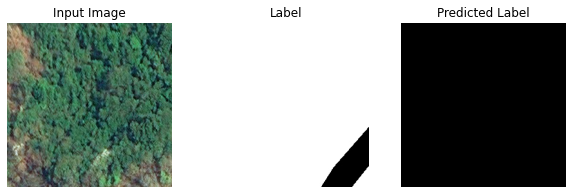

In [ ]:
show_predictions(val_generator, 5)

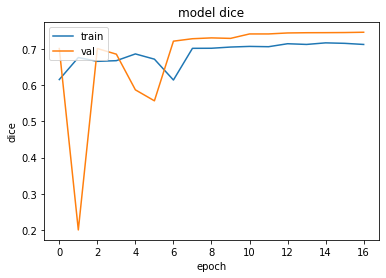

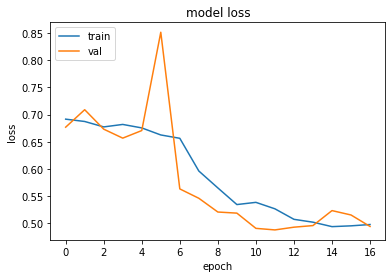

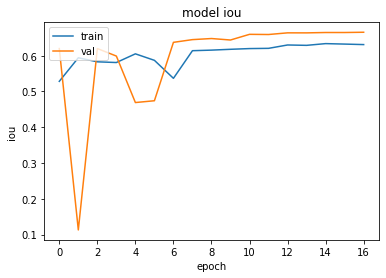

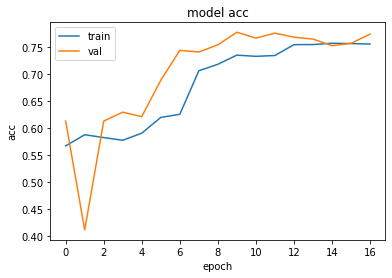

In [ ]:
#dice
plt.plot(model_history.history['dice_coef'])
plt.plot(model_history.history['val_dice_coef'])
plt.title('model dice')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#iou
plt.plot(model_history.history['iou_coef'])
plt.plot(model_history.history['val_iou_coef'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('fcn8-c1-iou-norm.h5')